In [ ]:
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import json
import tensorflow as tf
import PIL
import keras.backend as K

In [ ]:
### Checking Intersection
labels_path = os.path.join('drive','MyDrive','CITY','Resized','labels_limited')
labels = os.listdir(labels_path)
labs = []
for i in range(6):
  label_name = labels[i]
  label_path = os.path.join(labels_path,label_name)
  label_img = cv.imread(label_path,cv.IMREAD_UNCHANGED)
  labs.append(label_img)
labs_ar = np.array(labs)
labs_ar = (np.arange(9) == labs_ar[...,None]).astype(np.int8)
labs1 = labs_ar.copy()
labs2 = labs_ar.copy()

In [15]:
3 * 5 + 1

16

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    
    y_true = y_true[...,1:]
    y_pred = y_pred[...,1:]
    
    numerator = 2 * K.sum(y_true * y_pred,axis=[0,1,2]) + smooth 
    denominator = K.sum(y_true,axis=[0,1,2]) + K.sum(y_pred,axis=[0,1,2]) + smooth
      
    dice_coef = K.mean( numerator / denominator )
    
    return dice_coef

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    print(intersection)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

dice_coef(labs1,labs2)

tf.Tensor(0, shape=(), dtype=int8)


TypeError: ignored

In [ ]:

def conv_block(inputs,conv_type,kernel,kernel_size,strides,padding='same',relu=True):
    if conv_type == 'ds':
        x = tf.keras.layers.SeparableConv2D(kernel,kernel_size,padding=padding,strides=strides)(inputs)
    else:
        x = tf.keras.layers.Conv2D(kernel,kernel_size,padding=padding,strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    if relu:
        x = tf.keras.activations.relu(x)
    return x

def _res_bottleneck(inputs,filters,kernel,t,s,r=False):
    tchannel = tf.keras.backend.int_shape(inputs)[-1]*t
    x = conv_block(inputs,'conv',tchannel,(1,1),strides=(1,1))
    x = tf.keras.layers.DepthwiseConv2D(kernel,strides=(s,s),depth_multiplier=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = conv_block(x,'conv',filters,(1,1),strides=(1,1),padding='same',relu=False)
    if r:
        x = tf.keras.layers.add([x,inputs])
    return x

def bottleneck_block(inputs,filters,kernel,t,strides,n):
    x = _res_bottleneck(inputs,filters,kernel,t,strides)
    for i in range(1,n):
        x = _res_bottleneck(x,filters,kernel,t,1,True)
    return x

def pyramid_pooling_block(input_tensor,bin_sizes):
    concat_list = [input_tensor]
#     w = 64
#     h = 32
    w = 32
    h = 64
    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size,h//bin_size),strides=(w//bin_size,h//bin_size))(input_tensor)
        x = tf.keras.layers.Conv2D(128,3,2,padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x:tf.image.resize(x,(w,h)))(x)
        concat_list.append(x)
    return tf.keras.layers.concatenate(concat_list)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(512,1024,3),name='input_layer') #(2048,1024,3)
# input_layer = tf.keras.layers.BatchNormalization()(input_layer)
lds_layer = conv_block(input_layer,'conv',32,(3,3),strides=(2,2))
lds_layer = conv_block(lds_layer,'ds',48,(3,3),strides=(2,2))
lds_layer = conv_block(lds_layer,'ds',64,(3,3),strides=(1,1)) 
gfe_layer = bottleneck_block(lds_layer,64,(3,3),t=6,strides=2,n=3) 
gfe_layer = bottleneck_block(gfe_layer,96,(3,3),t=6,strides=2,n=3)
gfe_layer = bottleneck_block(gfe_layer,128,(3,3),t=6,strides=1,n=3) 
gfe_layer = pyramid_pooling_block(gfe_layer,[2,4,6,8]) 
ff_layer1 = conv_block(lds_layer,'conv',128,(1,1),padding='same',strides=(1,1),relu=False)
ff_layer2 = tf.keras.layers.UpSampling2D((4,4))(gfe_layer)
ff_layer2 = tf.keras.layers.DepthwiseConv2D(128,strides=(1,1),depth_multiplier=1,padding='same')(ff_layer2)
ff_layer2 = tf.keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = tf.keras.activations.relu(ff_layer2)
ff_layer2 = tf.keras.layers.Conv2D(128,1,1,padding='same',activation=None)(ff_layer2)
ff_final = tf.keras.layers.add([ff_layer1,ff_layer2])
ff_final = tf.keras.layers.BatchNormalization()(ff_final)
ff_final = tf.keras.activations.relu(ff_final)
classifier = tf.keras.layers.SeparableConv2D(128,(3,3),padding='same',strides=(1,1),name="DSConv1_classifier")(ff_final)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = tf.keras.layers.SeparableConv2D(128,(3,3),padding='same',strides=(1,1),name="DSConv2_classifier")(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = conv_block(classifier,'conv',9,(1,1),strides=(1,1),padding='same',relu=True) # classes number

classifier = tf.keras.layers.Dropout(0.1)(classifier)

classifier = tf.keras.layers.UpSampling2D((4,4))(classifier) #(8,8)
classifier = tf.keras.activations.softmax(classifier)

# compiling model
fast_scnn = tf.keras.Model(inputs=input_layer, outputs=classifier, name = 'Fast_SCNN')
optimizer = tf.keras.optimizers.SGD(momentum=0.9,lr=0.12) 
weights = os.path.join('drive','MyDrive','CITY','fast_scnn_weight_last.h5')
fast_scnn.load_weights(weights)
# fast_scnn.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# colors = [(0,0,0),(247,183,79),(79,247,239),(32,22,219),(150,150,153),(230,32,213),(255,0,0),(245,241,5),(5,245,45)]
#       #  0       ,   person  ,    sky     ,     vehicle ,   building  ,  road    ,   bike    ,  ground  ,   trees

colors = np.array([[0,0,0],[247,183,79],[79,247,239],[0,0,255],[150,150,0],[255,0,255],[255,0,0],[245,241,5],[0,255,0]])
      #  0       ,   person  ,    sky     ,  vehicle ,   building  ,  road    ,   bike   , ground  ,   trees

def label_to_seg(pred,p = True):
  if p:
    pred_label = np.argmax(pred,axis=3)
    pred_label = pred_label[0]
  else:
    pred_label = pred
  print(np.unique(pred_label))
  label = np.zeros((512,1024,3))
  
  for rid,r in enumerate(pred_label):
    for cid,c in enumerate(r):
      label[rid,cid,:] = colors[c]
  return label

(-0.5, 1023.5, 511.5, -0.5)

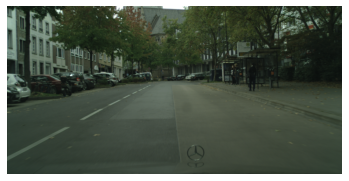

In [ ]:
'bochum_000000_027057'
'aachen_000047_000019'
plt.imshow(test_img[0])
plt.axis('off')

In [ ]:
images_path = os.path.join('drive','MyDrive','CITY','Resized','images')
labels_path = os.path.join('drive','MyDrive','CITY','Resized','labels_limited')
# label_name = os.listdir(labels_path)[0]
# image_name = os.listdir(images_path)[0]

name = 'aachen_000047_000019'

label_name = name+'_gtFine_labelIds.png'
image_name = name+'_leftImg8bit.png'
test_image = cv.imread(os.path.join(images_path,image_name))
test_image = cv.cvtColor(test_image,cv.COLOR_BGR2RGB)
test_label = cv.imread(os.path.join(labels_path,label_name),cv.IMREAD_UNCHANGED)

test_img = np.expand_dims(test_image,0)
# cv.imwrite('drive/MyDrive/fast_scnn/img_2.png',cv.cvtColor(test_image,cv.COLOR_RGB2BGR))
pred = fast_scnn.predict(test_img)

label_new = label_to_seg(pred)
# cv.imwrite('drive/MyDrive/fast_scnn/pred_2.png',cv.cvtColor(label_new,cv.COLOR_RGB2BGR))
test_label_new = label_to_seg(test_label,False)
# cv.imwrite('drive/MyDrive/fast_scnn/true_2.png',cv.cvtColor(test_label_new,cv.COLOR_RGB2BGR))

[0 3 4 5 8]
[0 1 2 3 4 5 6 7 8]


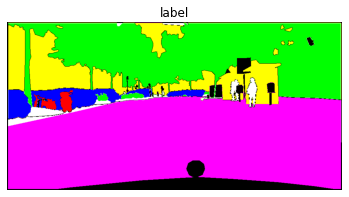

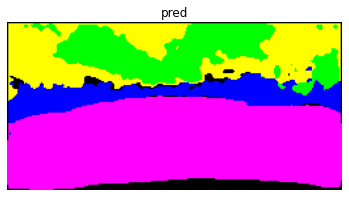

In [ ]:
rows,columns = 1,2

#fig = plt.figure(figsize=(rows+20,columns+20))

#fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(test_label_new)
plt.axis('off')
plt.title("label")
plt.show()
# Adds a subplot at the 2nd position
#fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(label_new)
plt.axis('off')
plt.title("pred")

plt.show()